### **"ModelsTest"**

**Libraries Used:**
- `pandas`: For data manipulation and analysis.
- `numpy`: For numerical operations.
- `matplotlib.pyplot`: For data visualization.
- `sklearn`: For machine learning algorithms and evaluation metrics.
- `xgboost`: For XGBoost classifier.
- `pmarima`: For auto ARIMA model.
- `statsmodels`: For Exponential Smoothing model.

**Models Implemented:**
1. **Random Forest Classifier:** Implemented using `RandomForestClassifier` from the `sklearn.ensemble` module.
2. **XGBoost Classifier:** Implemented using `XGBClassifier` from the `xgboost` library.
3. **Histogram-Based Gradient Boosting Classifier:** Implemented using `HistGradientBoostingClassifier` from the `sklearn.ensemble` module.
4. **Support Vector Classifier (SVC):** Implemented using `SVC` from the `sklearn.svm` module.
5. **Decision Tree Classifier:** Implemented using `DecisionTreeClassifier` from the `sklearn.tree` module.
6. **K-Nearest Neighbors (KNN) Classifier:** Implemented using `KNeighborsClassifier` from the `sklearn.neighbors` module.
7. **Naive Bayes Classifiers:** Gaussian, Bernoulli, and Multinomial Naive Bayes classifiers implemented using `GaussianNB`, `BernoulliNB`, and `MultinomialNB` from the `sklearn.naive_bayes` module.
8. **Auto ARIMA Model:** Implemented using `auto_arima` from the `pmarima` library.
9. **Exponential Smoothing Model:** Implemented using `ExponentialSmoothing` from the `statsmodels` library.

**Evaluation Metric:**
- ROC AUC Score: Used to evaluate the classification models' performance.

**Note:**
- Further analysis and optimization techniques such as hyperparameter tuning, feature engineering, and cross-validation can be applied to improve model performance.
- The specific domain and context of the dataset are not provided, which limits the interpretation of the results and recommendations for real-world applications.

----------

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('../data/drinking_water_potability.csv')
df.columns

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability'],
      dtype='object')

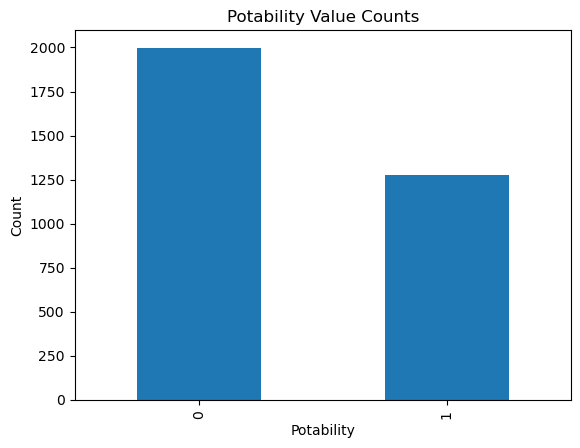

Potability
0    1998
1    1278
Name: count, dtype: int64


In [6]:
# Bar plot to count the values of 'Potability'
df['Potability'].value_counts().plot(kind='bar')
plt.xlabel('Potability')
plt.ylabel('Count')
plt.title('Potability Value Counts')
plt.show()

# Print the counts of each 'Potability' value
print(df['Potability'].value_counts())


## **Class Balancing**

In [7]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df[df.Potability == 0]
df_minority = df[df.Potability == 1]

# Downsample the majority class to match the size of the minority class
df_majority_downsampled = resample(df_majority, replace=False, n_samples=len(df_minority), random_state=42)

# Concatenate the downsampled majority class with the minority class to create a balanced dataset
df_balanced = pd.concat([df_majority_downsampled, df_minority])


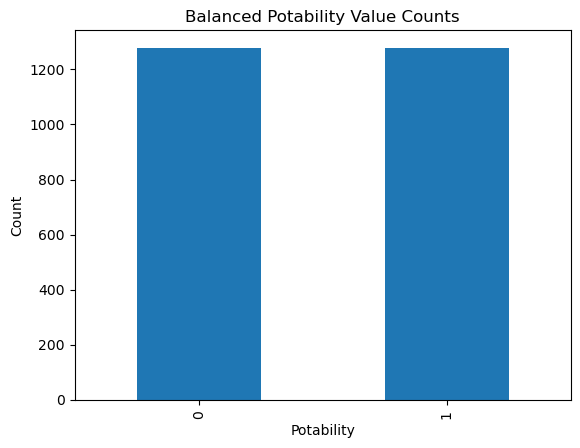

In [9]:
# Bar plot to visualize the counts of 'Potability' values in the balanced DataFrame
df_balanced['Potability'].value_counts().plot(kind='bar')
plt.xlabel('Potability')
plt.ylabel('Count')
plt.title('Balanced Potability Value Counts')
plt.show()


## **Class Balancing**

In [11]:
# Features (X): DataFrame with the 'Potability' column dropped
X = df_balanced.drop('Potability', axis=1)

# Target variable (y): Series containing only the 'Potability' column
y = df_balanced['Potability']


## **Data Perparation**

In [13]:
from sklearn.preprocessing import OneHotEncoder

# Identify columns with object data type (categorical variables)
object_columns = X.select_dtypes(include=['object']).columns

# Initialize OneHotEncoder with parameters for handling sparsity and dropping the first category
enc = OneHotEncoder(sparse=False, drop='first')

# Apply one-hot encoding to the categorical variables and create a DataFrame with the encoded features
X_encoded = pd.DataFrame(enc.fit_transform(X[object_columns]))

# Obtain the categories of the one-hot encoded features
categories = enc.categories_

# Create column names for the encoded features based on the original column names and categories
encoded_column_names = [f"{col}_{cat}" for col, cats in zip(object_columns, categories) for cat in cats[1:]]

# Set column names for the encoded features
X_encoded.columns = encoded_column_names

# Drop the original categorical columns from the feature set
X = X.drop(object_columns, axis=1).reset_index(drop=True)


c:\Users\nesto\anaconda3\envs\deep_learning\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [15]:
# Concatenate the original features (X) with the encoded features (X_encoded)
X = pd.concat([X, X_encoded], axis=1)


In [17]:
X

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,6.262799,206.889748,31414.525810,4.528076,349.734662,567.027274,15.963540,73.022605,4.012518
1,7.803833,223.688111,37376.792990,6.664969,333.775777,343.764013,16.697408,74.782434,2.907387
2,8.692115,144.236358,2552.962804,9.202634,347.975137,517.427471,13.963421,42.388661,2.283475
3,7.344976,182.306942,5689.804405,6.764350,373.872785,360.184473,20.483902,73.488981,3.418763
4,6.527441,181.072995,22444.081780,10.474977,271.862792,351.063788,11.996365,66.396293,3.567181
...,...,...,...,...,...,...,...,...,...
2551,4.668102,193.681736,47580.991600,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821
2552,7.808856,193.553212,17329.802160,8.061362,333.775777,392.449580,19.903225,66.396293,2.798243
2553,9.419510,175.762646,33155.578220,7.350233,333.775777,432.044783,11.039070,69.845400,3.298875
2554,5.126763,230.603758,11983.869380,6.303357,333.775777,402.883113,11.168946,77.488213,4.708658


In [20]:
from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Get column names before scaling
columns = X.columns

# Scale the features in X and create a DataFrame with the scaled features
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=columns)


In [21]:
X_scaled

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,0.453314,0.578391,0.510515,0.326894,0.627033,0.731939,0.554831,0.559872,0.480353
1,0.569061,0.639323,0.608408,0.494166,0.581699,0.308083,0.584415,0.575066,0.269723
2,0.635780,0.351132,0.036647,0.692809,0.622034,0.637776,0.474203,0.295386,0.150810
3,0.534596,0.489223,0.088150,0.501945,0.695601,0.339256,0.737055,0.563899,0.367187
4,0.473191,0.484747,0.363233,0.792405,0.405825,0.321941,0.394908,0.502662,0.395475
...,...,...,...,...,...,...,...,...,...
2551,0.333535,0.530482,0.775947,0.533436,0.656047,0.654856,0.471422,0.505178,0.561031
2552,0.569439,0.530016,0.279263,0.603473,0.581699,0.400510,0.713647,0.502662,0.248921
2553,0.690415,0.465486,0.539101,0.547807,0.581699,0.475680,0.356318,0.532441,0.344338
2554,0.367986,0.664407,0.191490,0.465860,0.581699,0.420318,0.361553,0.598427,0.613032


## **Separation of train and test**

In [22]:
from sklearn.model_selection import train_test_split

# Split the scaled features and target variable into training and testing sets
# with a test size of 20% and a random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


## **Function to measure error**

In [23]:
from sklearn.metrics import roc_auc_score

def mide_error(model_name, y_pred):
    # Calculate the ROC AUC score using the predicted probabilities (y_pred) and the true labels (y_test)
    auc = roc_auc_score(y_test, y_pred)
    
    # Print the model name and its corresponding ROC AUC score
    print(f'{model_name} AUC: {auc:.4f}')


# **3. Dataset for time series**

## **3.1 File upload**

In [24]:
import statsmodels.api as sm

df_st = sm.datasets.macrodata.load_pandas().data.loc[:, ['year', 'quarter','infl']]
df_st['period'] = pd.PeriodIndex(year=df_st.year, quarter=df_st.quarter, freq='Q')
df_st.set_index('period', inplace=True)
df_st.drop(['year', 'quarter'], axis=1, inplace=True)
df_st.head()

,infl
period,
1959Q1,0.00
1959Q2,2.34
1959Q3,2.74
1959Q4,0.27
1960Q1,2.31


## **3.2 Separación de train y test**

In [27]:
# Extract the 'infl' column from the DataFrame for training data
train_data = df_st.iloc[:len(X_train)]['infl'].values.astype(np.float64)


# **4 Logistic regression**
------

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# Define logistic regression model
logreg = LogisticRegression(solver='saga', max_iter=1000, random_state=42)

# Define hyperparameters to search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

# Perform grid search with cross-validation to find the best hyperparameters
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# Get the best model and its corresponding hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Fit the best model to the training data
best_model.fit(X_train, y_train)

# Predict probabilities for the positive class using the test data
y_pred = best_model.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
auc = roc_auc_score(y_test, y_pred)

# Print the best hyperparameters and the ROC AUC score
print("Best Hyperparameters:", best_params)
print("ROC AUC Score:", auc)


Best Hyperparameters: {'C': 0.001, 'penalty': 'l1'}
ROC AUC Score: 0.5


# **5 KNN**

In [34]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

# Initialize KNN classifier with specified number of neighbors
knn = KNeighborsClassifier(n_neighbors=16)

# Fit the KNN classifier to the training data
knn.fit(X_train, y_train)

# Predict probabilities for the positive class using the test data
y_pred = knn.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
auc = roc_auc_score(y_test, y_pred)

# Print the ROC AUC score
print(f'KNN AUC: {auc:.4f}')


KNN AUC: 0.6593


# **6 Naive bayes**

In [35]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.metrics import roc_auc_score

# Initialize Gaussian Naive Bayes classifier
nb_G = GaussianNB()
# Fit the Gaussian Naive Bayes classifier to the training data
nb_G.fit(X_train, y_train)

# Initialize Bernoulli Naive Bayes classifier
nb_B = BernoulliNB()
# Fit the Bernoulli Naive Bayes classifier to the training data
nb_B.fit(X_train, y_train)

# Initialize Multinomial Naive Bayes classifier
nb_M = MultinomialNB()
# Fit the Multinomial Naive Bayes classifier to the training data
nb_M.fit(X_train, y_train)

# Predict probabilities for the positive class using the test data for each classifier
y_pred_G = nb_G.predict_proba(X_test)[:, 1]
y_pred_B = nb_B.predict_proba(X_test)[:, 1]
y_pred_M = nb_M.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score for each classifier
auc_G = roc_auc_score(y_test, y_pred_G)
auc_B = roc_auc_score(y_test, y_pred_B)
auc_M = roc_auc_score(y_test, y_pred_M)

# Print the ROC AUC score for each classifier
print(f'Naive Bayes Gaussian AUC: {auc_G:.4f}')
print(f'Naive Bayes Bernoulli AUC: {auc_B:.4f}')
print(f'Naive Bayes Multinomial AUC: {auc_M:.4f}')


Naive Bayes Gaussian AUC: 0.5948
Naive Bayes Bernoulli AUC: 0.5019
Naive Bayes Multinomial AUC: 0.5142


# **7 K-Means**

In [38]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Initialize KMeans clustering with a range of number of clusters
best_silhouette_score = -1
best_n_clusters = 0

for n_clusters in range(2, 21):  # Try different numbers of clusters from 2 to 20
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10, max_iter=300, tol=0.0001, algorithm='auto')
    kmeans.fit(X_train)
    y_pred = kmeans.predict(X_test)
    silhouette_avg = silhouette_score(X_test, y_pred)
    print(f'Number of clusters: {n_clusters}, Silhouette Score: {silhouette_avg:.4f}')
    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_n_clusters = n_clusters

print(f'Best number of clusters: {best_n_clusters}, Best Silhouette Score: {best_silhouette_score:.4f}')


c:\Users\nesto\anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Number of clusters: 2, Silhouette Score: 0.1039


c:\Users\nesto\anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Number of clusters: 3, Silhouette Score: 0.0790


c:\Users\nesto\anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Number of clusters: 4, Silhouette Score: 0.0861


c:\Users\nesto\anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Number of clusters: 5, Silhouette Score: 0.0791


c:\Users\nesto\anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Number of clusters: 6, Silhouette Score: 0.0767


c:\Users\nesto\anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Number of clusters: 7, Silhouette Score: 0.0740


c:\Users\nesto\anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Number of clusters: 8, Silhouette Score: 0.0679


c:\Users\nesto\anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Number of clusters: 9, Silhouette Score: 0.0679


c:\Users\nesto\anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Number of clusters: 10, Silhouette Score: 0.0685


c:\Users\nesto\anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Number of clusters: 11, Silhouette Score: 0.0649


c:\Users\nesto\anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Number of clusters: 12, Silhouette Score: 0.0633


c:\Users\nesto\anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Number of clusters: 13, Silhouette Score: 0.0632


c:\Users\nesto\anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Number of clusters: 14, Silhouette Score: 0.0672


c:\Users\nesto\anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Number of clusters: 15, Silhouette Score: 0.0588


c:\Users\nesto\anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Number of clusters: 16, Silhouette Score: 0.0529


c:\Users\nesto\anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Number of clusters: 17, Silhouette Score: 0.0557


c:\Users\nesto\anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Number of clusters: 18, Silhouette Score: 0.0536


c:\Users\nesto\anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Number of clusters: 19, Silhouette Score: 0.0520


c:\Users\nesto\anaconda3\envs\deep_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Number of clusters: 20, Silhouette Score: 0.0520
Best number of clusters: 2, Best Silhouette Score: 0.1039


# **8 Decision tree**

In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

# Initialize Decision Tree classifier with specified maximum depth
tree = DecisionTreeClassifier(max_depth=8, random_state=42)

# Fit the Decision Tree classifier to the training data
tree.fit(X_train, y_train)

# Predict probabilities for the positive class using the test data
y_pred = tree.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
auc = roc_auc_score(y_test, y_pred)

# Print the ROC AUC score
print(f'Decision Tree AUC: {auc:.4f}')


Decision Tree AUC: 0.6156


# **9 Arima**
---------
(When data is seasonal)

In [ ]:
from pmarima import auto_arima

# Fit auto_arima model to training data
model = auto_arima(train_data, 
                   seasonal=True, 
                   m=4, 
                   max_p=3, 
                   max_q=3, 
                   max_P=3, 
                   max_Q=3, 
                   max_order=None, 
                   max_d=2, 
                   max_D=1, 
                   maxiter=50, 
                   alpha=0.05, 
                   n_jobs=-1, 
                   trend='ct', 
                   information_criterion='aic', 
                   out_of_sample_size=0, 
                   scoring='mse', 
                   start_p=2, 
                   start_q=2, 
                   start_P=1, 
                   start_Q=1, 
                   seasonal_test='ocsb', 
                   stepwise=True, 
                   suppress_warnings=True, 
                   error_action='trace', 
                   random=False, 
                   random_state=None, 
                   n_fits=10, 
                   return_valid_fits=False, 
                   with_intercept=True, 
                   sarimax_kwargs=None)

# Fit the model
model_fit = model.fit(train_data)

# Make predictions
predictions = model_fit.predict(n_periods=len(test_data))

# Evaluate the predictions
mide_error('ARIMA', predictions)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_st[-12:].index.strftime('%Y-%m'), df_st[-12:].infl, label='Reality')
plt.plot(df_st[-4:].index.strftime('%Y-%m'), predictions, label='Predictions')
plt.xticks(rotation=45, fontsize=12)
plt.legend()
plt.show()


# **10 Exponential Smoothing**

In [ ]:
from statsmodels.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

# Fit Exponential Smoothing model to training data
model = ExponentialSmoothing(train_data, trend='add', seasonal=None, seasonal_periods=4)
model_fit = model.fit()

# Make predictions
predictions = model_fit.predict(start=len(train_data), end=len(train_data)+len(test_data)-1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_st[-12:].index.strftime('%Y-%m'), df_st[-12:].infl, label='Reality')
plt.plot(df_st[-4:].index.strftime('%Y-%m'), predictions, label='Predictions')
plt.xticks(rotation=45, fontsize=12)
plt.legend()
plt.show()


# **11 Random Forest**

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Initialize Random Forest classifier with specified parameters
rf = RandomForestClassifier(n_estimators=100, max_depth=14, random_state=42)

# Fit the Random Forest classifier to the training data
rf.fit(X_train, y_train)

# Predict probabilities for the positive class using the test data
y_pred = rf.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
auc = roc_auc_score(y_test, y_pred)

# Print the ROC AUC score
print(f'Random Forest AUC: {auc:.4f}')


Random Forest AUC: 0.6924


# **12 XGBOOST**

In [44]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# Initialize XGBoost classifier with specified parameters
xgb_classifier = XGBClassifier(n_estimators=100, max_depth=14, random_state=42)

# Fit the XGBoost classifier to the training data
xgb_classifier.fit(X_train, y_train)

# Predict probabilities for the positive class using the test data
y_pred = xgb_classifier.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
auc = roc_auc_score(y_test, y_pred)

# Print the ROC AUC score
print(f'XGBoost AUC: {auc:.4f}')


XGBoost AUC: 0.6613


# **13 LIGHTGBM**

In [45]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score

# Initialize Histogram-Based Gradient Boosting classifier with specified parameters
hist_gradient_boosting = HistGradientBoostingClassifier(max_iter=100, max_depth=10, random_state=42)

# Fit the Histogram-Based Gradient Boosting classifier to the training data
hist_gradient_boosting.fit(X_train, y_train)

# Predict probabilities for the positive class using the test data
y_pred = hist_gradient_boosting.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
auc = roc_auc_score(y_test, y_pred)

# Print the ROC AUC score
print(f'Hist Gradient Boosting AUC: {auc:.4f}')


Hist Gradient Boosting AUC: 0.6822


# **14 SVM**

In [46]:
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

# Initialize Support Vector Classifier with specified parameters
svc = SVC(probability=True, 
          random_state=42, 
          kernel='rbf', 
          C=2.0, 
          gamma='scale', 
          degree=3, 
          coef0=0.0, 
          shrinking=True, 
          tol=0.001, 
          cache_size=400, 
          class_weight=None)

# Fit the Support Vector Classifier to the training data
svc.fit(X_train, y_train)

# Predict probabilities for the positive class using the test data
y_pred = svc.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
auc = roc_auc_score(y_test, y_pred)

# Print the ROC AUC score
print(f'SVC AUC: {auc:.4f}')


SVC AUC: 0.7028
